Training...
Episode 100, Epsilon: 0.606
Episode 200, Epsilon: 0.367
Episode 300, Epsilon: 0.222
Episode 400, Epsilon: 0.135
Episode 500, Epsilon: 0.082
Episode 600, Epsilon: 0.049
Episode 700, Epsilon: 0.030
Episode 800, Epsilon: 0.018
Episode 900, Epsilon: 0.011
Episode 1000, Epsilon: 0.010
Episode 1100, Epsilon: 0.010
Episode 1200, Epsilon: 0.010
Episode 1300, Epsilon: 0.010
Episode 1400, Epsilon: 0.010
Episode 1500, Epsilon: 0.010
Episode 1600, Epsilon: 0.010
Episode 1700, Epsilon: 0.010
Episode 1800, Epsilon: 0.010
Episode 1900, Epsilon: 0.010
Episode 2000, Epsilon: 0.010

Testing learned policy...


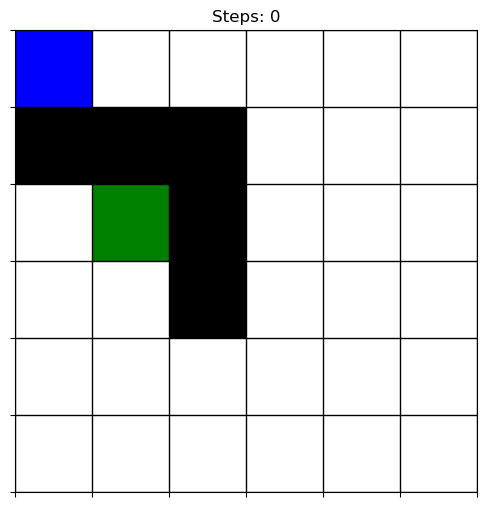

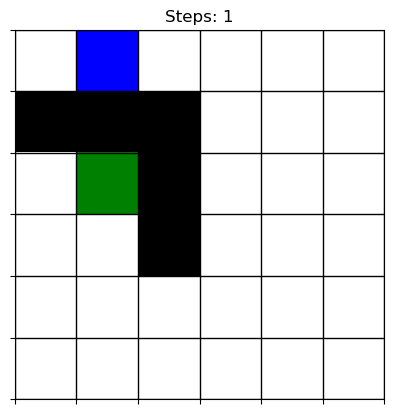

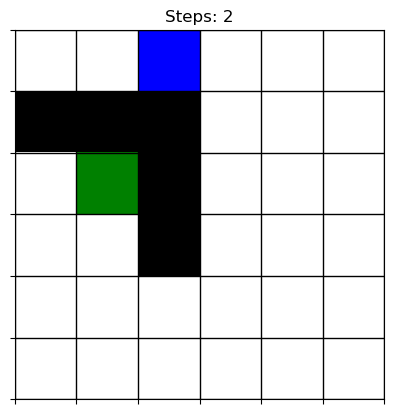

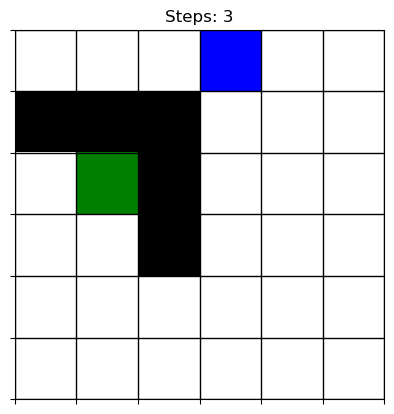

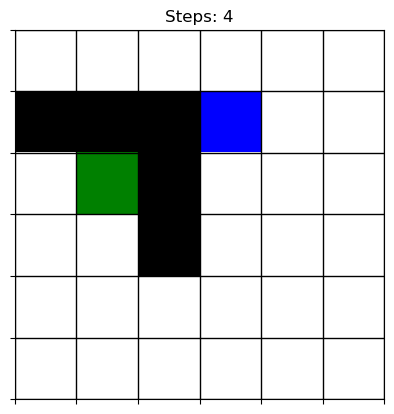

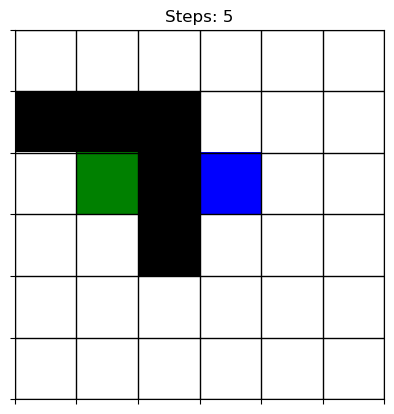

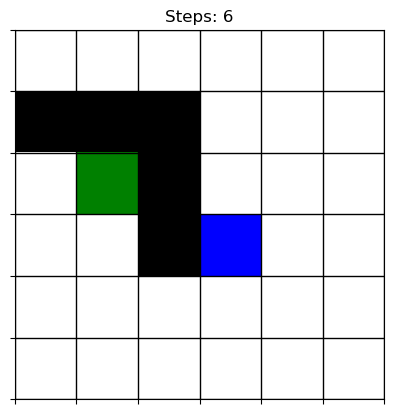

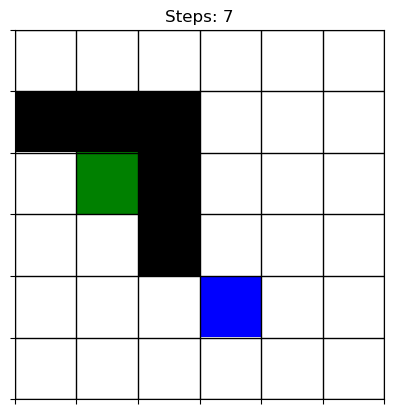

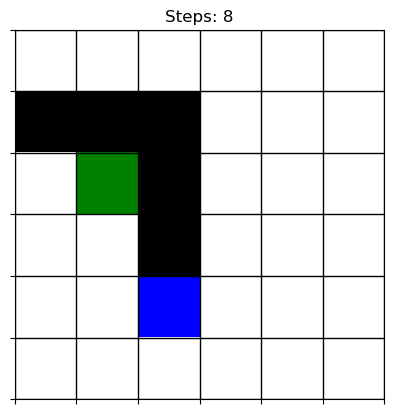

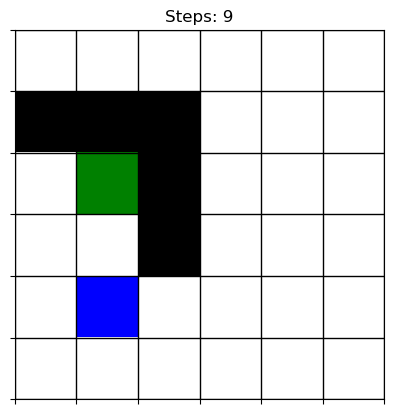

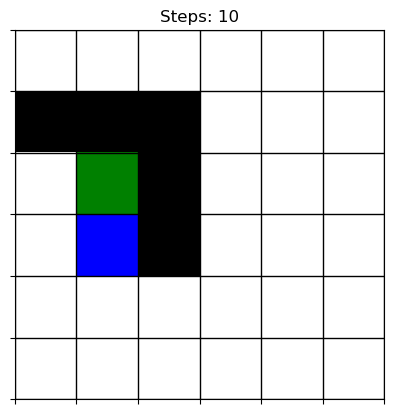

Done.


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class Agent:
    def __init__(self):
        self.start = None
        self.pos = None

    def set_position(self, start):
        self.start = tuple(start)

    def reset(self):
        self.pos = tuple(self.start)

    def move(self, action, height, width):
        r, c = self.pos
        if action == 0: r -= 1     # Up
        elif action == 1: c += 1   # Right
        elif action == 2: r += 1   # Down
        elif action == 3: c -= 1   # Left

        if 0 <= r < height and 0 <= c < width:
            self.pos = (r, c)
        return self.pos

class GridWorld:
    def __init__(self, height=5, width=5, start=None, goal=None,
                 reward_goal=1, reward_step=-1, obstacles=None, obstacle_penalty=-10):
        self.height, self.width = height, width
        self.obstacles = set(tuple(o) for o in obstacles) if obstacles else set()

        self.start = tuple(start) if start else self._random_free_cell([])
        self.goals = [tuple(g) for g in goal] if goal else [self._random_free_cell([self.start] + list(self.obstacles))]

        for g in self.goals:
            assert g not in self.obstacles
        assert self.start not in self.obstacles

        self.agent = Agent()
        self.agent.set_position(self.start)

        self.reward_goal = reward_goal
        self.reward_step = reward_step
        self.obstacle_penalty = obstacle_penalty
        self._steps = 0

        self.cmap = colors.ListedColormap(["white", "blue", "green", "black"])
        self.norm = colors.BoundaryNorm([0, 2, 3, 4, 5], self.cmap.N)

    def _random_free_cell(self, exclude=[]):
        exclude_set = set(exclude)
        while True:
            cell = (np.random.randint(0, self.height), np.random.randint(0, self.width))
            if cell not in exclude_set and cell not in self.obstacles:
                return cell

    def set_random_goal(self):
        exclude = list(self.obstacles) + [self.agent.pos]
        self.goals = [self._random_free_cell(exclude=exclude)]

    def set_start_position(self, pos):
        assert pos not in self.obstacles and pos not in self.goals
        self.start = pos
        self.agent.set_position(pos)

    def reset(self, randomize_goal=False):
        if randomize_goal:
            self.set_random_goal()
        self.agent.reset()
        self._steps = 0
        return self._get_obs()

    def step(self, action):
        self._steps += 1
        new_pos = self.agent.move(action, self.height, self.width)
        if new_pos in self.goals:
            return self._get_obs(), self.reward_goal, True
        elif new_pos in self.obstacles:
            return self._get_obs(), self.obstacle_penalty, False
        else:
            return self._get_obs(), self.reward_step, False

    def _get_obs(self):
        grid = np.zeros((self.height, self.width), dtype=np.int8)
        for r, c in self.obstacles:
            grid[r, c] = 4
        for r, c in self.goals:
            grid[r, c] = 3
        ar, ac = self.agent.pos
        grid[ar, ac] = 2
        return grid

    def render(self, pause_time=1):
        grid = self._get_obs()
        plt.clf()
        plt.imshow(grid, cmap=self.cmap, norm=self.norm, extent=[0, self.width, self.height, 0])
        plt.xticks(np.arange(0, self.width + 1, 1), [])
        plt.yticks(np.arange(0, self.height + 1, 1), [])
        plt.grid(color="black", linewidth=1)
        plt.title(f"Steps: {self._steps}")
        plt.pause(pause_time)


class LinearQAgent:
    def __init__(self, env, gamma=0.9, alpha=0.1, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.num_features = env.height * env.width * 4
        self.w = np.zeros(self.num_features)

    def featurize(self, state, action):
        r, c = state
        feat = np.zeros(self.num_features)
        idx = (r * self.env.width + c) * 4 + action
        feat[idx] = 1.0
        return feat

    def q_value(self, state, action):
        return np.dot(self.w, self.featurize(state, action))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(4)
        else:
            return np.argmax([self.q_value(state, a) for a in range(4)])

    def learn(self, num_episodes=1000, max_steps=100, random_start=False, moving_goal=False):
        for ep in range(num_episodes):
            if random_start:
                while True:
                    rand_pos = (np.random.randint(0, self.env.height), np.random.randint(0, self.env.width))
                    if rand_pos not in self.env.obstacles and rand_pos not in self.env.goals:
                        self.env.set_start_position(rand_pos)
                        break
            if moving_goal:
                self.env.set_random_goal()

            self.env.reset()
            state = self.env.agent.pos
            done = False
            steps = 0

            while not done and steps < max_steps:
                action = self.choose_action(state)
                phi = self.featurize(state, action)
                obs, reward, done = self.env.step(action)
                next_state = self.env.agent.pos
                
                # FIXED: Terminal state should have Q-value of 0
                if done:
                    q_next = 0
                else:
                    q_next = max(self.q_value(next_state, a) for a in range(4))
                
                td_error = (reward + self.gamma * q_next) - self.q_value(state, action)
                self.w += self.alpha * td_error * phi
                state = next_state
                steps += 1

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            if (ep + 1) % 100 == 0:
                print(f"Episode {ep+1}, Epsilon: {self.epsilon:.3f}")

    def act(self, state):
        return np.argmax([self.q_value(state, a) for a in range(4)])

    def get_q_grid(self):
        q_grid = np.zeros((self.env.height, self.env.width, 4))
        for r in range(self.env.height):
            for c in range(self.env.width):
                for a in range(4):
                    q_grid[r, c, a] = self.q_value((r, c), a)
        return q_grid


if __name__ == "__main__":
    height, width = 6, 6
    start = (0, 0)
    goals = [(2, 1)]
    obstacles = [(1, 1),(1,0), (1, 2), (2, 2), (3, 2)]

    env = GridWorld(height=height, width=width, start=start, goal=goals,
                    reward_goal=10, reward_step=-1, obstacles=obstacles)

    agent = LinearQAgent(env, gamma=0.95, alpha=0.2, epsilon=1.0,
                         epsilon_min=0.01, epsilon_decay=0.995)

    print("Training...")
    # Train with fixed goal and random starts for better learning
    agent.learn(num_episodes=2000, max_steps=50, random_start=True, moving_goal=False)

    # Reset to original start position for testing
    env.set_start_position(start)
    env.reset()
    agent.epsilon = 0
    done = False
    steps = 0
    print("\nTesting learned policy...")

    plt.figure(figsize=(6, 6))
    plt.ion()
    
    while not done and steps < 50:
        env.render(pause_time=0.3)
        action = agent.act(env.agent.pos)
        _, _, done = env.step(action)
        steps += 1

    plt.ioff()
    plt.show()
    print("Done.")